In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
from matplotlib.colors import LinearSegmentedColormap, ListedColormap
import seaborn as sns
import os
import sys
import pickle
from glob import glob


from olympus.surfaces import (
    Dejong,
    CatCamel,
    CatMichalewicz,
    CatDejong,
    CatSlope,
    MultViennet,
    MultFonseca,
    MultZdt1,
    MultZdt2,
    MultZdt3,
)

from mpl_toolkits.axes_grid1 import make_axes_locatable

In [37]:
# Golem colormap
_olympus_reference_colors = [
    "#08294C",
    "#75BBE1",
    "#D4E9F4",
    "#F2F2F2",
    "#F7A4D4",
    "#F75BB6",
    "#EB0789",
]
_olympus_cmap = LinearSegmentedColormap.from_list(
    "olympus", _olympus_reference_colors
)
_olympus_cmap_r = LinearSegmentedColormap.from_list(
    "olympus_r", _olympus_reference_colors[::-1]
)

plt.register_cmap(cmap=_olympus_cmap)
plt.register_cmap(cmap=_olympus_cmap_r)


def get_golem_colors(n):
    _cmap = plt.get_cmap('olympus')
    return [_cmap(x) for x in np.linspace(0, 1, n)]

def plot_contour(ax, X0, X1, y, xlims, ylims, vlims=[None, None], alpha=0.5, contour_lines=False, contour_labels=True, 
                 labels_fs=8, labels_fmt='%d', n_contour_lines=8, contour_color='k', contour_alpha=1, cbar=False, cmap='olympus'):
    # background surface
    if contour_lines is True:
        contours = ax.contour(X0, X1, y, n_contour_lines, colors=contour_color, alpha=contour_alpha, linestyles='dashed')
        if contour_labels is True:
            _ = ax.clabel(contours, inline=True, fontsize=labels_fs, fmt=labels_fmt)
    mappable = ax.imshow(y, extent=[xlims[0],xlims[1],ylims[0],ylims[1]], 
                         origin='lower', cmap=cmap, alpha=alpha, vmin=vlims[0], vmax=vlims[1])
    
    if cbar is True:
        cbar = plt.colorbar(mappable=mappable, ax=ax, shrink=0.5)
        
    return mappable

def plot_surface(surface, ax=None, N=100, obj_ix=0):
    
    if ax is None:
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,5))

    x0 = np.linspace(0,1,N)
    x1 = np.linspace(0,1,N)
    X0, X1 = np.meshgrid(x0,x1)
    X = np.array([X0.flatten(), X1.flatten()]).T
    y = np.array(surface.run(X))
    y = y[:, obj_ix]

    Y = np.reshape(y, newshape=X0.shape)
    

    _ =  plot_contour(ax, X0, X1, Y, xlims=[0,1], ylims=[0,1], alpha=1, contour_lines=False, contour_labels=False, 
                 labels_fs=8, labels_fmt='%d', n_contour_lines=8, contour_alpha=0.8, cbar=False, cmap='olympus')
#     for param in surface.minima:
#         x_min = param['params']
#         ax.scatter(x_min[0], x_min[1], s=200, marker='*', color='#ffc6ff', zorder=20)
    
    params = [{'x0':x[0], 'x1':x[1]} for x in X]
#     y_feas = surface.eval_constr(params)
#     Y_feas = np.reshape(y_feas, newshape=np.shape(X0))
#     ax.imshow(Y_feas, extent=[0,1,0,1], origin='lower', cmap='gray', alpha=0.5, interpolation='nearest')


def plot_surface_cat(surface, ax=None, mark_min=True):
    if ax is None:
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,5))
    domain = np.arange(surface.num_opts)
    Z = np.zeros((surface.num_opts, surface.num_opts))
    X = []
    for x_index, x in enumerate(domain):
        for y_index, y in enumerate(domain):
            x = ['x{}'.format(x_index), 'x{}'.format(y_index)]
            X.append(x)
            loss_value = surface.run(x)[0][0]
            Z[y_index, x_index] = loss_value
        
    # scale Camel for visualization 
    if type(surface).__name__ == 'CatCamel':
        Z = np.log(Z)
    im = ax.imshow(Z, origin='lower', cmap = plt.get_cmap('olympus'))
    #if mark_min is True:
    #    X_best = surface.str2array(surface.best)
    #    _ = ax.scatter(X_best[0], X_best[1], marker='*', s=200, color='#ffc6ff', linewidth=2, zorder=20)
        #_ = ax.scatter(X_best[0], X_best[1], marker='o', s=100, color='none', linewidth=2, edgecolor='#ec091f', zorder=20)
        #_ = ax.scatter(X_best[0], X_best[1], marker='s', s=70, color='none', linewidth=3, edgecolor='#ffc6ff', zorder=20)
        #_ = ax.scatter(X_best[0], X_best[1], marker='*', s=300, color='none', linewidth=3, edgecolor='#ffc6ff', zorder=1)
        
    return im

/home/riley/Software/anaconda3/envs/atlas/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: Trying to register the cmap 'olympus' which already exists.
/home/riley/Software/anaconda3/envs/atlas/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: Trying to register the cmap 'olympus_r' which already exists.


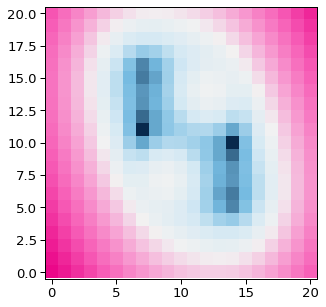

In [38]:
surf = CatCamel(param_dim=2, num_opts=21)
plot_surface_cat(surf)

In [39]:
surf.run(['x1', 'x2'])

[[415915.9507169602]]

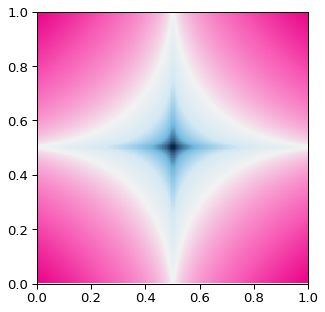

In [40]:
surf = Dejong(param_dim=2)
plot_surface(surf)

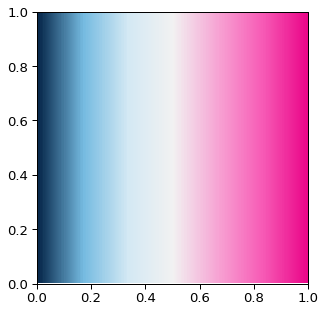

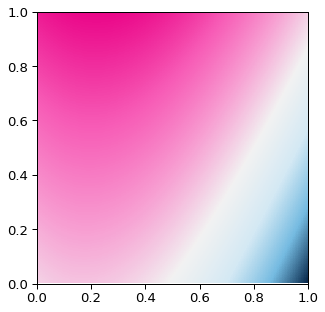

In [41]:
surf = MultZdt2()
surf.run([0.2,0.7])
plot_surface(surf, obj_ix=0)
plot_surface(surf, obj_ix=1)


In [42]:
len(surf.value_space)

2

## Plot categorical surfaces

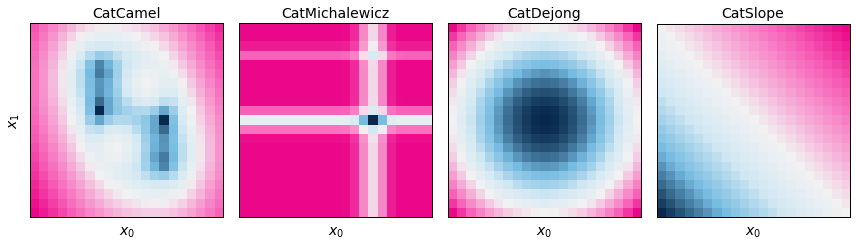

In [43]:
fig, axes = plt.subplots(1, 4, figsize=(12, 5), sharey=True)

# catcamel
surf = CatCamel(param_dim=2, num_opts=21)
plot_surface_cat(surf, ax=axes[0])
axes[0].set_title(type(surf).__name__, fontsize=14)

# catmichalewicz
surf = CatMichalewicz(param_dim=2, num_opts=21)
plot_surface_cat(surf, ax=axes[1])
axes[1].set_title(type(surf).__name__, fontsize=14)

# catdejong
surf = CatDejong(param_dim=2, num_opts=21)
plot_surface_cat(surf, ax=axes[2])
axes[2].set_title(type(surf).__name__, fontsize=14)

# catslope
surf = CatSlope(param_dim=2, num_opts=21)
im = plot_surface_cat(surf, ax=axes[3])
axes[3].set_title(type(surf).__name__, fontsize=14)

for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel(r'$x_0$', fontsize=14)
   
axes[0].set_ylabel(r'$x_1$', fontsize=14)

plt.tight_layout()
plt.savefig('categorical_synthetic_functions.png', dpi=400)

## Plot multiobjective surfaces

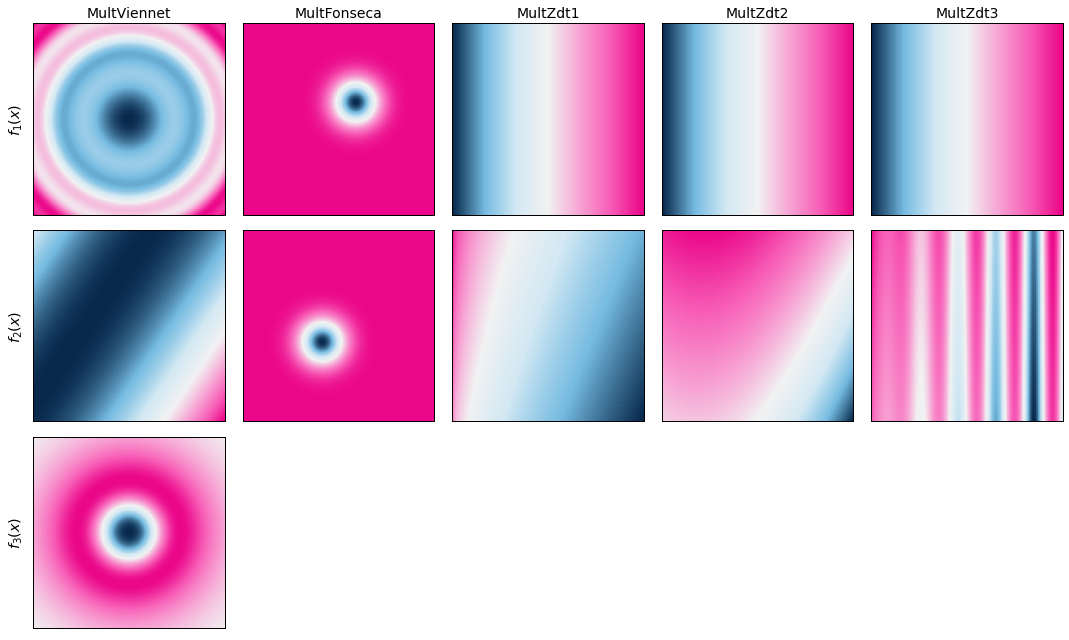

In [44]:
fig, axes = plt.subplots(3, 5, figsize=(15, 9), sharey=True, sharex=True)

# multviennet
surf = MultViennet()
plot_surface(surf, obj_ix=0, ax=axes[0, 0])
plot_surface(surf, obj_ix=1, ax=axes[1, 0])
plot_surface(surf, obj_ix=2, ax=axes[2, 0])
axes[0, 0].set_title(type(surf).__name__, fontsize=14)


# multfonseca
surf = MultFonseca()
plot_surface(surf, obj_ix=0, ax=axes[0, 1])
plot_surface(surf, obj_ix=1, ax=axes[1, 1])
axes[0, 1].set_title(type(surf).__name__, fontsize=14)


# multzdt1
surf = MultZdt1()
plot_surface(surf, obj_ix=0, ax=axes[0, 2])
plot_surface(surf, obj_ix=1, ax=axes[1, 2])
axes[0, 2].set_title(type(surf).__name__, fontsize=14)

# multzdt2
surf = MultZdt2()
plot_surface(surf, obj_ix=0, ax=axes[0, 3])
plot_surface(surf, obj_ix=1, ax=axes[1, 3])
axes[0, 3].set_title(type(surf).__name__, fontsize=14)

# multzdt3
surf = MultZdt3()
plot_surface(surf, obj_ix=0, ax=axes[0, 4])
plot_surface(surf, obj_ix=1, ax=axes[1, 4])
axes[0, 4].set_title(type(surf).__name__, fontsize=14)


for i in [1, 2, 3, 4]:
    fig.delaxes(axes[-1, i])

for ax in axes.flatten():
    ax.set_xticks([])
    ax.set_yticks([])
    
for i in [0, 1, 2]:

    axes[i, 0].set_ylabel(f'$f_{i+1}(x)$')
    
plt.tight_layout()
plt.savefig('moo_synthetic_functions.png', dpi=400)